In [1]:
import pandas as pd
from pandas.plotting import scatter_matrix
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import KFold
from scipy.optimize import minimize
import random

In [2]:
# read pd
df = pd.read_csv('MN_selected.csv')
df

,id,AssessTot,LotFront,NumFloors,ComArea,ResArea,OfficeArea,RetailArea,GarageArea,StrgeArea,...,LandUse_8,LandUse_9,LandUse_10,OwnerType_C,OwnerType_M,OwnerType_O,OwnerType_P,OwnerType_X,Zone,LandUse
0,0,156510900,0.00,0.0,2725731,0,0,0,0,0,...,1,0,0,0,0,0,1,0,L Manhattan,8
1,1,12197250,500.00,0.0,541886,0,0,0,0,0,...,1,0,0,0,0,0,0,1,L Manhattan,8
2,6,25390080,311.00,5.0,158197,0,0,0,0,0,...,0,0,0,1,0,0,0,0,L Manhattan,7
3,8,17134650,793.67,2.0,24346,0,0,0,0,0,...,0,0,0,1,0,0,0,0,L Manhattan,7
4,9,129665250,323.00,1.0,945425,0,0,0,0,0,...,0,1,0,1,0,0,0,0,L Manhattan,9
5,19,327600,19.00,4.5,4104,0,1026,3078,0,0,...,0,0,0,0,0,0,1,0,L Manhattan,4
6,22,943650,36.17,5.0,4485,2990,1495,2990,0,0,...,0,0,0,0,0,0,1,0,L Manhattan,4
7,26,535090,28.42,5.0,3012,4473,1491,1521,0,0,...,0,0,0,0,0,0,1,0,L Manhattan,4
8,29,6046650,78.92,7.5,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,L Manhattan,5
9,33,138236850,211.33,32.0,845018,0,839651,5367,0,0,...,0,0,0,0,0,0,1,0,L Manhattan,5


## Currently we are underfitting land with low values.

In [6]:
for i in range(len(df.columns)):
    print (i,df.columns[i])

0 id
1 AssessTot
2 LotFront
3 NumFloors
4 ComArea
5 ResArea
6 OfficeArea
7 RetailArea
8 GarageArea
9 StrgeArea
10 FactryArea
11 OtherArea
12 YearBuilt
13 CommFAR
14 PopDensity
15 MedIncome
16 NumofHouses
17 EduRate
18 UnemployedRate
19 IfAlter
20 Central Harlem
21 Chelsea & Clinton
22 East Harlem
23 Gramercy Park and Murray Hill
24 GV & Soho
25 L Manhattan
26 L. East Side
27 U Eest Side
28 U West Side
29 WAHI
30 LandUse_1
31 LandUse_2
32 LandUse_3
33 LandUse_4
34 LandUse_5
35 LandUse_6
36 LandUse_7
37 LandUse_8
38 LandUse_9
39 LandUse_10
40 OwnerType_C
41 OwnerType_M
42 OwnerType_O
43 OwnerType_P
44 OwnerType_X
45 Zone
46 LandUse


In [7]:
# convert to np
data = df.as_matrix()

In [8]:
# # plotting
# plt.plot(data[:,2],data[:,1],'.')
# plt.xlabel('LotArea')
# plt.ylabel('AssesTot')
# plt.show()

In [9]:
# log scale AssessTot
data[:,1] = np.log(1.0*np.hstack(data[:,1]))

In [10]:
def outliers_iqr(ys):
    quartile_1, quartile_3 = np.percentile(ys, [25, 75])
    iqr = quartile_3 - quartile_1
    lower_bound = quartile_1 - (iqr * 10)
    upper_bound = quartile_3 + (iqr * 10)
    return np.where((ys > upper_bound) | (ys < lower_bound))

In [11]:
# remove outliers
index = np.zeros(len(data))
for i in range(1,5):
    index[outliers_iqr(data[:,i])] = 1
data = data[np.where(index==0)]

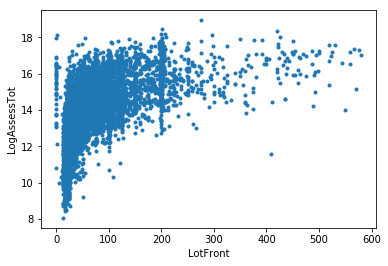

In [12]:
# plotting
plt.plot(data[:,2],data[:,1],'.')
plt.xlabel('LotFront')
plt.ylabel('LogAssessTot')
plt.show()

In [44]:
# import seaborn as sns
# # sns.set(style="ticks")
# plt.figure(figsize=(15,6))
# plt.xlabel('Zone')
# plt.ylabel('AssessTot')
# sns.boxplot(y=np.hstack(data[:,1]), x=np.hstack(data[:,46]),width=0.8,order=[u'Central Harlem', u'Chelsea & Clinton', u'East Harlem', u'G Park & M Hill', u'GV & Soho', u'L Manhattan',u'L. East Side', u'U Eest Side', u'U West Side', u'WAHI'])
# # sns.boxplot(y=np.hstack(data[:,1]), x=np.hstack(data[:,33]),width=0.8)
# # plt.legend()
# plt.show()

In [66]:
# plt.figure(figsize=(15,6))
# plt.xlabel('LandUse')
# plt.ylabel('AssessTot')
# sns.boxplot(y=np.hstack(data[:,1]), x=np.hstack(data[:,34]),width=0.8)
# plt.show()

In [12]:
# # scaling
# data = data[:,1:33].astype(float)
# temp = data[:,:6]
# temp = (temp - temp.min(axis = 0))/(temp.max(axis=0)-temp.min(axis = 0))
# data = np.hstack((temp,data[:,6:]))
# # adding offset
# data = np.hstack((data,np.ones((len(data),1))))

In [51]:
# # scaling
# data = data[:,1:33].astype(float)
# temp = data[:,1:6]
# temp = (temp - temp.min(axis = 0))/(temp.max(axis=0)-temp.min(axis = 0))
# # scaler = StandardScaler()
# # scaler.fit(np.reshape(data[:,0],(len(data[:,0]),1)))
# # temp = scaler.transform(temp)
# data = np.hstack((np.column_stack((data[:,0],temp)),data[:,6:]))
# # adding offset
# data = np.hstack((data,np.ones((len(data),1))))

In [13]:
np.max(data[:,4:12],axis=0)

array([79000, 1176100, 78589, 71305, 78896, 73150, 65307, 79000],
      dtype=object)

In [14]:
# scaling
data = data[:,1:45].astype(float)
temp = data[:,1:18]
temp = (temp - temp.min(axis = 0))/(temp.max(axis=0)-temp.min(axis = 0))
# scaler = StandardScaler()
# scaler.fit(np.reshape(data[:,0],(len(data[:,0]),1)))
# temp = scaler.transform(temp)
data = np.hstack((np.column_stack((data[:,0],temp)),data[:,18:]))
# adding offset
data = np.hstack((data,np.ones((len(data),1))))

In [15]:
data[2,:]

array([1.31901902e+01, 4.90990446e-02, 1.92307692e-01, 3.81265823e-02,
       3.80324802e-03, 1.89721208e-02, 2.13309025e-02, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 5.37848606e-01,
       1.00000000e+00, 0.00000000e+00, 4.14539687e-01, 0.00000000e+00,
       9.88304094e-01, 2.91666667e-01, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       1.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       1.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 1.00000000e+00, 0.00000000e+00,
       1.00000000e+00])

In [16]:
# partitioning, randomly select 80% samples as traininig set, 20% as test set
n = int(len(data)*0.8)
trainset = random.sample(range(len(data)),n)
testset = [i for i in range(len(data)) if i not in trainset]
X = data[trainset,1:]
Y = data[trainset,0]
X_test = data[testset,1:]
Y_test = data[testset,0]

In [17]:
# coefficient plot
def coef_plot(w):
    plt.bar(range(len(w)),w)
    plt.xlabel('predictors')
    plt.ylabel('coefficients')
    plt.title('regression results - coefficients')
    plt.show()

In [18]:
# true value, predicted value
def pred_value_plot(Y,Y_pred):
    plt.figure(figsize=(5,5))
    plt.plot(np.exp(Y),np.exp(Y_pred),'.')
    plt.plot(np.exp(Y),np.exp(Y))
#     plt.plot(Y,Y_pred,'.')
#     plt.plot(Y,Y)
    plt.xscale('log')
    plt.yscale('log')
    plt.xlabel('true value')
    plt.ylabel('predicted value')
    plt.title('predicted value vs true value of test set')
    plt.show()

In [19]:
# residual plot
def residual_plot(Y,Y_pred):
    plt.plot(Y_pred,Y-Y_pred,'.')
    plt.plot([8,20],[0,0])
    plt.xlabel('fitted value')
    plt.ylabel('residual')
    plt.show()

In [20]:
X

array([[0.04319057, 0.19230769, 0.        , ..., 1.        , 0.        ,
        1.        ],
       [0.04146295, 0.11538462, 0.        , ..., 1.        , 0.        ,
        1.        ],
       [0.05873918, 0.03846154, 0.0278481 , ..., 1.        , 0.        ,
        1.        ],
       ...,
       [0.03469067, 0.15384615, 0.01474684, ..., 1.        , 0.        ,
        1.        ],
       [0.02936959, 0.11538462, 0.        , ..., 1.        , 0.        ,
        1.        ],
       [0.13820984, 0.15384615, 0.09113924, ..., 1.        , 0.        ,
        1.        ]])

## L2 loss, no reg, package

In [21]:
# l2 loss, no regularizor, python linear regression package
# create linear regression object
regr = linear_model.LinearRegression(fit_intercept=False)
# train the model
regr.fit(X,Y)
# test the model
Y_pred = regr.predict(X)
Y_test_pred = regr.predict(X_test)
# the coefficients
np.set_printoptions(precision=4, suppress=True)
print('coefficients:', regr.coef_)
# mean squared error
print('mean_squared_error train: %.4f' % mean_squared_error(Y,Y_pred))
print('mean_squared_error test: %.4f' % mean_squared_error(Y_test,Y_test_pred))

coefficients: [ 5.3533  3.5272  1.0463 -0.8617 -0.3496  2.8124 -0.9407 -0.4603 -0.5645
  0.2943  0.9595  0.3053  0.1243  1.051  -0.0977  0.3708  0.5491  0.2508
  0.1409  0.9875  0.2533  1.0036  0.9429  0.6103  0.9355  1.2777  0.9979
  0.433  -0.5966  0.3807  1.175   0.8172  1.1257  0.9603  0.7341  1.0445
  0.7254  1.2164  1.8657  0.6232  1.7177  1.6712  1.7048  7.5826]
mean_squared_error train: 0.6311
mean_squared_error test: 0.6874


In [22]:
np.exp(0.6)

1.8221188003905089

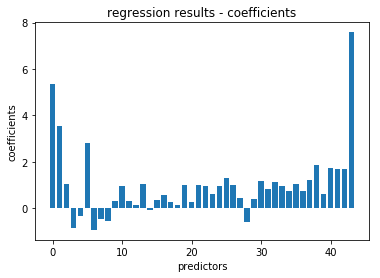

In [23]:
coef_plot(regr.coef_)

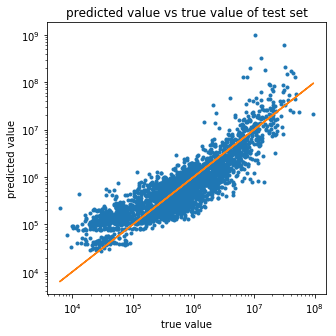

In [24]:
pred_value_plot(Y_test,Y_test_pred)

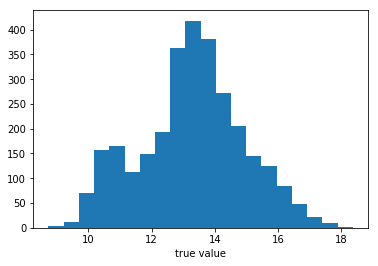

In [25]:
plt.hist(Y_test,bins=20)
plt.xlabel('true value')
plt.show()

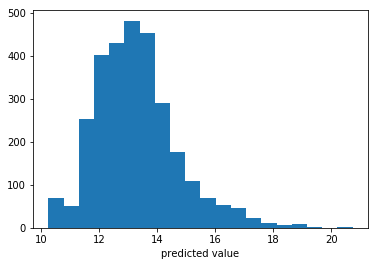

In [26]:
plt.hist(Y_test_pred,bins=20)
plt.xlabel('predicted value')
plt.show()

We have a lot of predicted values between 12-14 because we have three categorical transferred dummis.

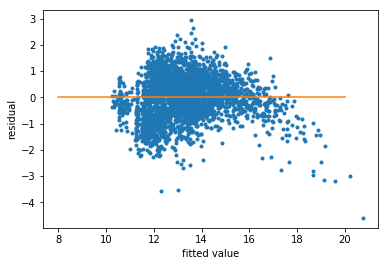

In [27]:
residual_plot(Y_test,Y_test_pred)

## L2 loss, no reg

In [28]:
# l2 loss, no regularizor, solve to the end
w = np.dot(np.linalg.pinv(X),Y)
Y_test_pred = np.dot(X_test,w)
print('mean_squared_error test: %.4f' % mean_squared_error(Y_test,Y_test_pred))

mean_squared_error test: 0.6874


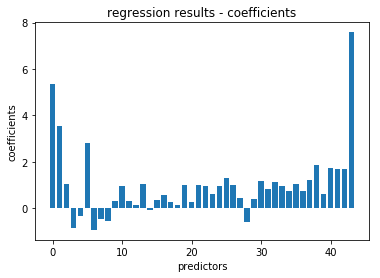

In [29]:
coef_plot(w)

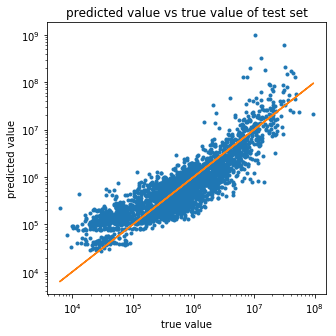

In [30]:
pred_value_plot(Y_test,Y_test_pred)

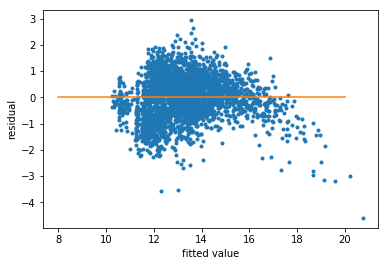

In [31]:
residual_plot(Y_test,Y_test_pred)

## L2 loss, lasso reg

In [32]:
# n-th fold cross validation
K = 10
kf = KFold(n_splits = K)
alpha_list = [0.0005,0.001,0.005,0.01]
error = np.zeros(len(alpha_list))
for i in range(len(alpha_list)):
    alpha = alpha_list[i]
    lasso = linear_model.Lasso(alpha=alpha, fit_intercept=False, normalize=False, max_iter=1000)
    for train_index, test_index in kf.split(X):
        Xv_train,Xv_test = X[train_index],X[test_index]
        Yv_train,Yv_test = Y[train_index],Y[test_index]
        lasso.fit(Xv_train,Yv_train)
        error[i] += mean_squared_error(Yv_test,lasso.predict(Xv_test))
error = error/(K*1.0)
error


C:\Users\georgesat19\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


array([0.6377, 0.6415, 0.6606, 0.6827])

In [33]:
lasso = linear_model.Lasso(alpha=0.0005, fit_intercept=False, normalize=False, max_iter=1000)
# lasso = linear_model.Lasso(alpha=alpha_list[np.argmin(error)], fit_intercept=False, normalize=False, max_iter=5000)
lasso.fit(X,Y)
Y_test_pred = lasso.predict(X_test)
mean_squared_error(Y_test,Y_test_pred)

C:\Users\georgesat19\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


0.6896713148954101

In [34]:
lasso.coef_[18:28]

array([5.89  , 6.729 , 5.9946, 6.747 , 6.6907, 6.3528, 6.6827, 7.0331,
       6.7406, 6.191 ])

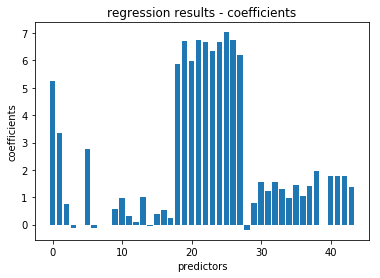

In [35]:
coef_plot(lasso.coef_)

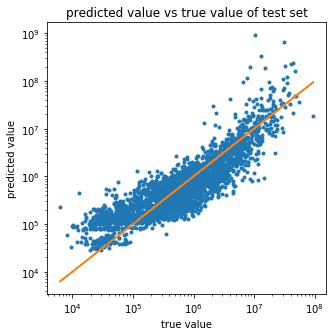

In [36]:
pred_value_plot(Y_test,Y_test_pred)

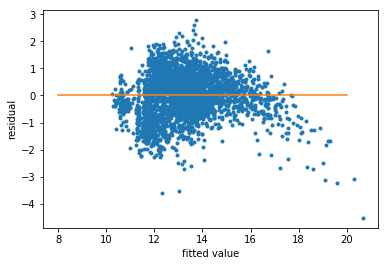

In [37]:
residual_plot(Y_test,Y_test_pred)

## L2 loss, smooth reg

In [64]:
# regression with regularization
# objective function of l2 loss smooth regularizor
def l2_smooth(w,X,Y,D,alpha=1.0):
     return mean_squared_error(Y,np.dot(X,w)) + alpha*np.square(np.linalg.norm(np.dot(D,w)))
# used to generate the D matrix in smooth regularizor 
def Dmatrix(n):
    r = 0
    t = np.zeros((int(n*(n-1)/2),n))
    for i in range(n-1):
        for j in range(i+1,n):
            t[r,i] = 1
            t[r,j] = -1
            r += 1
    return t

In [65]:
# stepsize for proximal gradient
U,s,V = np.linalg.svd(X)
step = 1.0/(2.0*np.square(s[0]))
# initial w
w0 = np.zeros(np.shape(X)[1])
# D matrix for smooth regularizor
D = np.zeros((100,np.shape(X)[1]))
D[0:45,18:28] = Dmatrix(10)
D[45:90,28:38] = Dmatrix(10)
D[90:100,38:43] = Dmatrix(5)

In [66]:
np.shape(w0)

(44,)

In [67]:
# smooth proximator
def prox_smooth(stepsize,alpha,D,z):
    return np.dot(np.linalg.inv(2.0*stepsize*alpha*np.dot(D.T,D) + np.eye(np.shape(D)[1])),z)
# l2_smooth proximal gradient method
def proxi_grad_l2_smooth(X,Y,D,alpha,maxiters=1000,stepsize=step,w=w0):
    obj = []
    for i in range(maxiters):
        g = 2.0*np.dot(X.T,np.dot(X,w)-Y)
        z = w - stepsize*g
        w = prox_smooth(stepsize,alpha,D,z)
        obj.append(l2_smooth(w,X,Y,D,alpha))
    return obj,w

In [68]:
# n-th fold cross validation
K = 10
kf = KFold(n_splits = K)
alpha_list = [0.01,0.1,0.5,1.0]
error = np.zeros(len(alpha_list))
for i in range(len(alpha_list)):
    alpha = alpha_list[i]
    for train_index, test_index in kf.split(X):
        Xv_train,Xv_test = X[train_index],X[test_index]
        Yv_train,Yv_test = Y[train_index],Y[test_index]
        obj,w = proxi_grad_l2_smooth(Xv_train,Yv_train,D,alpha)
        error[i] += mean_squared_error(Yv_test,np.dot(Xv_test,w))
error = error/(K*1.0)
error

array([0.6652, 0.6652, 0.6653, 0.6653])

In [69]:
np.argmin(error)

0

In [70]:
# obj,w = proxi_grad_l2_smooth(X,Y,D,alpha_list[np.argmin(error)])
obj,w = proxi_grad_l2_smooth(X,Y,D,5.0)
Y_test_pred = np.dot(X_test,w)
print('mean_squared_error test: %.4f' % mean_squared_error(Y_test,Y_test_pred))

mean_squared_error test: 0.7162


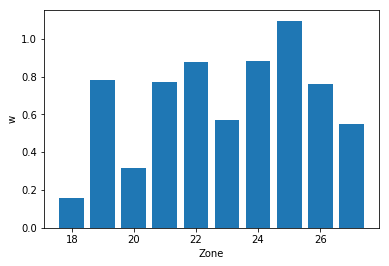

In [71]:
# smoothed coefficients for zones 
plt.bar(range(18,28),w[18:28])
plt.xlabel('Zone')
plt.ylabel('w')
plt.show()

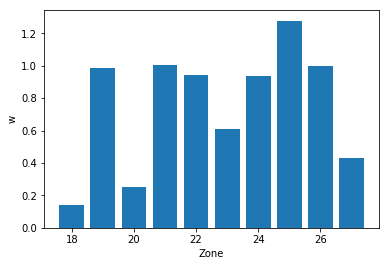

In [72]:
# original coefficients for zones
plt.bar(range(18,28),regr.coef_[18:28])
plt.xlabel('Zone')
plt.ylabel('w')
plt.show()

From the plot, classify zone into {0,2}{1,3,4,6,8}{7}{5,9}

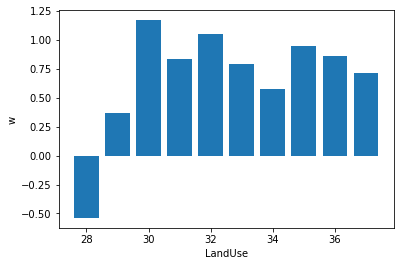

In [73]:
# smoothed coefficients for Landuse 
plt.bar(range(28,38),w[28:38])
plt.xlabel('LandUse')
plt.ylabel('w')
plt.show()

From the plot, classify landuse into {0}{1}{2,4,7}{3,5,6,8,9}

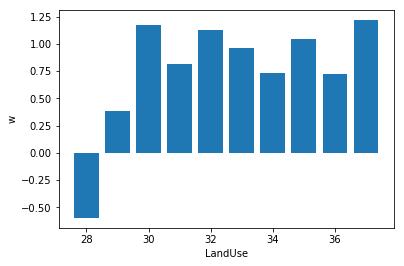

In [74]:
# original coefficients for LandUse
plt.bar(range(28,38),regr.coef_[28:38])
plt.xlabel('LandUse')
plt.ylabel('w')
plt.show()

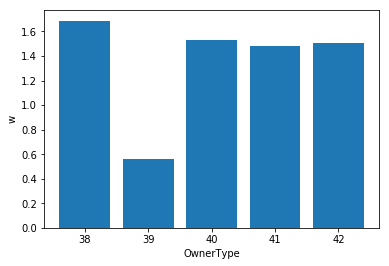

In [75]:
plt.bar(range(38,43),w[38:43])
plt.xlabel('OwnerType')
plt.ylabel('w')
plt.show()

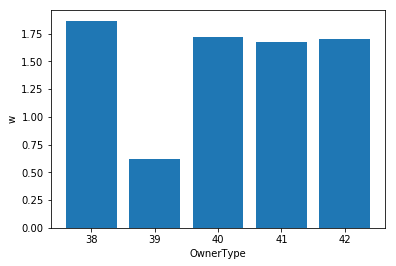

In [76]:
plt.bar(range(38,43),regr.coef_[38:43])
plt.xlabel('OwnerType')
plt.ylabel('w')
plt.show()

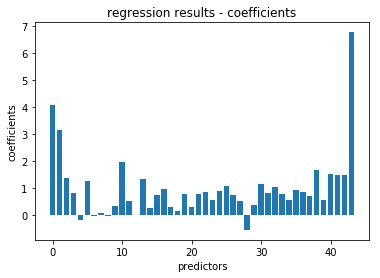

In [77]:
coef_plot(w)

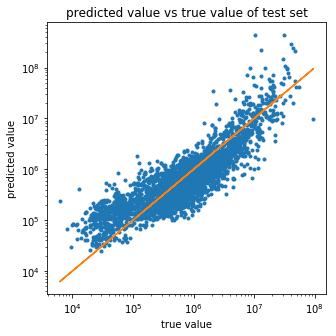

In [78]:
pred_value_plot(Y_test,Y_test_pred)

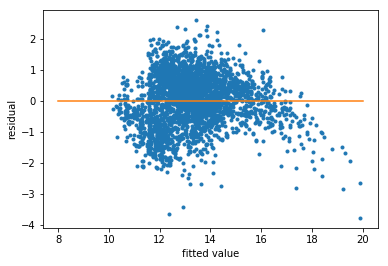

In [79]:
residual_plot(Y_test,Y_test_pred)

## l2 loss, ridge reg

In [80]:
# stepsize for proximal gradient
U,s,V = np.linalg.svd(X)
step = 1.0/(2.0*np.square(s[0]))
# initial w
w0 = np.zeros(np.shape(X)[1])

In [81]:
# ridge proximator
def prox_ridge(stepsize,alpha,z):
    return z/(2.0*stepsize*alpha+1)
# l2_ridge objective value
def l2_ridge(w,X,Y,alpha):
    return mean_squared_error(Y,np.dot(X,w)) + alpha*np.square(np.linalg.norm(w))
# l2_ridge proximal gradient method
def proxi_grad_l2_ridge(X,Y,alpha,maxiters=1000,stepsize=step,w=w0):
    obj = []
    for i in range(maxiters):
        g = 2.0*np.dot(X.T,np.dot(X,w)-Y)
        z = w - stepsize*g
        w = prox_ridge(stepsize,alpha,z)
        obj.append(l2_ridge(w,X,Y,alpha))
    return obj,w

In [82]:
# n-th fold cross validation
K = 10
kf = KFold(n_splits = K)
alpha_list = [0.001,0.01,0.1,1.0,3.0,6.0,10.0,30.0,60.0]
error = np.zeros(len(alpha_list))
for i in range(len(alpha_list)):
    alpha = alpha_list[i]
    for train_index, test_index in kf.split(X):
        Xv_train,Xv_test = X[train_index],X[test_index]
        Yv_train,Yv_test = Y[train_index],Y[test_index]
        obj,w = proxi_grad_l2_ridge(Xv_train,Yv_train,alpha)
        error[i] += mean_squared_error(Yv_test,np.dot(Xv_test,w))
error = error/(K*1.0)
error

array([0.6652, 0.6653, 0.6653, 0.6661, 0.668 , 0.6709, 0.675 , 0.6984,
       0.7375])

In [83]:
obj,w = proxi_grad_l2_ridge(X,Y,alpha_list[np.argmin(error)],maxiters=1000)
Y_test_pred = np.dot(X_test,w)
print('mean_squared_error test: %.4f' % mean_squared_error(Y_test,Y_test_pred))

mean_squared_error test: 0.7151


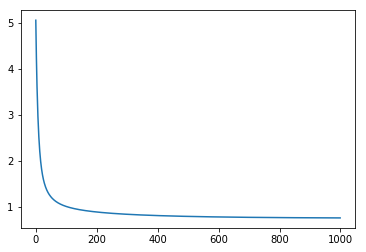

In [86]:
plt.plot(range(1000),obj)
plt.show()

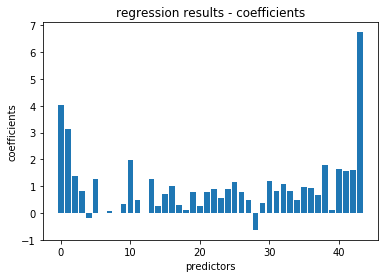

In [87]:
coef_plot(w)

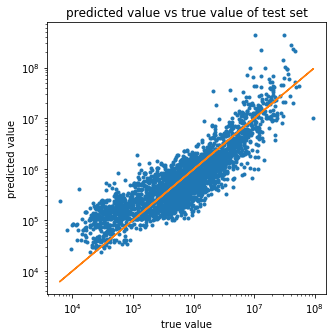

In [88]:
pred_value_plot(Y_test,Y_test_pred)

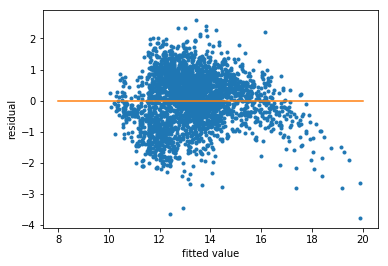

In [89]:
# residual = true - fitted
residual_plot(Y_test,Y_test_pred)
# plt.hist(Y_test-Y_test_pred)
# plt.xlabel('residual')
# plt.show()

## Huber,ridge

In [90]:
# n-th fold cross validation
K = 10
kf = KFold(n_splits = K)
epsilon_list = [2.0,3.0,4.0,5.0,6.0]
error = np.zeros(len(epsilon_list))
for i in range(len(epsilon_list)):
    huber = linear_model.HuberRegressor(epsilon=epsilon_list[i], max_iter=1000, alpha=0.)
    for train_index, test_index in kf.split(X):
        Xv_train,Xv_test = X[train_index],X[test_index]
        Yv_train,Yv_test = Y[train_index],Y[test_index]
        huber.fit(Xv_train,Yv_train)
        error[i] += mean_squared_error(Yv_test,huber.predict(Xv_test))
error = error/(K*1.0)
error

array([0.6389, 0.6373, 0.6372, 0.6371, 0.6371])

In [91]:
huber = linear_model.HuberRegressor(epsilon=epsilon_list[np.argmin(error)], max_iter=1000, alpha=0)
# lasso = linear_model.Lasso(alpha=alpha_list[np.argmin(error)], fit_intercept=False, normalize=False, max_iter=5000)
huber.fit(X,Y)
Y_test_pred = huber.predict(X_test)
mean_squared_error(Y_test,Y_test_pred)

0.6873551204558661

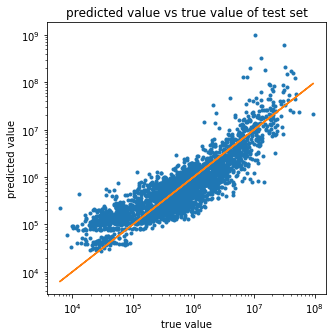

In [92]:
pred_value_plot(Y_test,Y_test_pred)

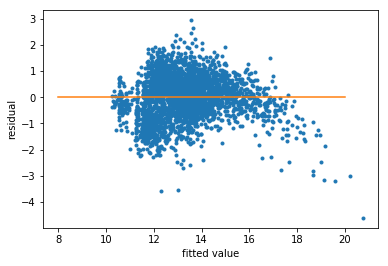

In [93]:
residual_plot(Y_test,Y_test_pred)

## two parts

In [94]:
# # n-th fold cross validation
K = 10
kf = KFold(n_splits = K)
t_list = [13,14,15,16,17]
error = np.zeros(len(t_list))
for i in range(len(t_list)):
    t = t_list[i]
    for train_index, test_index in kf.split(X):
        Xv_train,Xv_test = X[train_index],X[test_index]
        Yv_train,Yv_test = Y[train_index],Y[test_index]
        # fit two parts model on Xv_train
        X1 = np.squeeze(Xv_train[np.where(Yv_train<=t),:])
        X2 = np.squeeze(Xv_train[np.where(Yv_train>t),:])
        Y1 = Yv_train[np.where(Yv_train<=t)]
        Y2 = Yv_train[np.where(Yv_train>t)]
        w = np.dot(np.linalg.pinv(Xv_train),Yv_train)
        w1 = np.dot(np.linalg.pinv(X1),Y1)
        w2 = np.dot(np.linalg.pinv(X2),Y2)
        rough = np.dot(Xv_test,w)
        X_test1 = np.squeeze(Xv_test[np.where(rough<=t),:])
        X_test2 = np.squeeze(Xv_test[np.where(rough>t),:])
        Y_test1 = Yv_test[np.where(rough<=t)]
        Y_test2 = Yv_test[np.where(rough>t)]
        Y_test1_pred = np.dot(X_test1,w1)
        Y_test2_pred = np.dot(X_test2,w2)
        mse1 = mean_squared_error(Y_test1,Y_test1_pred)
        mse2 = mean_squared_error(Y_test2,Y_test2_pred)
        error[i] += (mse1*len(Y_test1)+mse2*len(Y_test2))/len(Yv_test)
error = error/(K*1.0)
error

array([0.541 , 0.526 , 0.5186, 0.5643, 3.5059])

In [104]:
# l2 loss, no regularizor, two parts
t = 15
X1 = np.squeeze(X[np.where(Y<=t),:])
X2 = np.squeeze(X[np.where(Y>t),:])
Y1 = Y[np.where(Y<=t)]
Y2 = Y[np.where(Y>t)]
w = np.dot(np.linalg.pinv(X),Y)
w1 = np.dot(np.linalg.pinv(X1),Y1)
w2 = np.dot(np.linalg.pinv(X2),Y2)
rough = np.dot(X_test,w)
X_test1 = np.squeeze(X_test[np.where(rough<=t),:])
X_test2 = np.squeeze(X_test[np.where(rough>t),:])
Y_test1 = Y_test[np.where(rough<=t)]
Y_test2 = Y_test[np.where(rough>t)]
Y_test1_pred = np.dot(X_test1,w1)
Y_test2_pred = np.dot(X_test2,w2)
mse1 = mean_squared_error(Y_test1,Y_test1_pred)
mse2 = mean_squared_error(Y_test2,Y_test2_pred)
print('mean_squared_error test: %.4f' % mse1)
print('mean_squared_error test: %.4f' % mse2)
print((mse1*len(Y_test1)+mse2*len(Y_test2))/len(Y_test))

mean_squared_error test: 0.5857
mean_squared_error test: 0.3028
0.5546730135717737


In [97]:
# # n-th fold cross validation
K = 10
kf = KFold(n_splits = K)
t_list = [13,14,15,16,17]
error = np.zeros(len(t_list))
huber = linear_model.HuberRegressor(epsilon=6, max_iter=1000, alpha=0.1)
huber1 = linear_model.HuberRegressor(epsilon=6, max_iter=1000, alpha=0.1)
huber2 = linear_model.HuberRegressor(epsilon=6, max_iter=1000, alpha=0.1)
for i in range(len(t_list)):
    t = t_list[i]
    for train_index, test_index in kf.split(X):
        Xv_train,Xv_test = X[train_index],X[test_index]
        Yv_train,Yv_test = Y[train_index],Y[test_index]
        # fit two parts model on Xv_train
        X1 = np.squeeze(Xv_train[np.where(Yv_train<=t),:])
        X2 = np.squeeze(Xv_train[np.where(Yv_train>t),:])
        Y1 = Yv_train[np.where(Yv_train<=t)]
        Y2 = Yv_train[np.where(Yv_train>t)]
        huber.fit(Xv_train,Yv_train)
        huber1.fit(X1,Y1)
        huber2.fit(X2,Y2)
        rough = huber.predict(Xv_test)
        X_test1 = np.squeeze(Xv_test[np.where(rough<=t),:])
        X_test2 = np.squeeze(Xv_test[np.where(rough>t),:])
        Y_test1 = Yv_test[np.where(rough<=t)]
        Y_test2 = Yv_test[np.where(rough>t)]
        Y_test1_pred = huber1.predict(X_test1)
        Y_test2_pred = huber2.predict(X_test2)
        mse1 = mean_squared_error(Y_test1,Y_test1_pred)
        mse2 = mean_squared_error(Y_test2,Y_test2_pred)
        error[i] += (mse1*len(Y_test1)+mse2*len(Y_test2))/len(Yv_test)
error = error/(K*1.0)
error

array([0.5809, 0.5061, 0.5153, 0.5641, 0.603 ])

In [105]:
# l2 loss, no regularizor, two parts
t = 14
huber = linear_model.HuberRegressor(epsilon=6, max_iter=1000, alpha=0.001)
huber1 = linear_model.HuberRegressor(epsilon=6, max_iter=1000, alpha=0.001)
huber2 = linear_model.HuberRegressor(epsilon=6, max_iter=1000, alpha=0.001)
X1 = np.squeeze(X[np.where(Y<=t),:])
X2 = np.squeeze(X[np.where(Y>t),:])
Y1 = Y[np.where(Y<=t)]
Y2 = Y[np.where(Y>t)]
huber.fit(X,Y)
huber1.fit(X1,Y1)
huber2.fit(X2,Y2)
rough = huber.predict(X_test)
X_test1 = np.squeeze(X_test[np.where(rough<=t),:])
X_test2 = np.squeeze(X_test[np.where(rough>t),:])
Y_test1 = Y_test[np.where(rough<=t)]
Y_test2 = Y_test[np.where(rough>t)]
Y_test1_pred = huber1.predict(X_test1)
Y_test2_pred = huber2.predict(X_test2)
mse1 = mean_squared_error(Y_test1,Y_test1_pred)
mse2 = mean_squared_error(Y_test2,Y_test2_pred)
print('mean_squared_error test: %.4f' % mse1)
print('mean_squared_error test: %.4f' % mse2)
print((mse1*len(Y_test1)+mse2*len(Y_test2))/len(Y_test))

mean_squared_error test: 0.6625
mean_squared_error test: 0.4121
0.6001583299007044


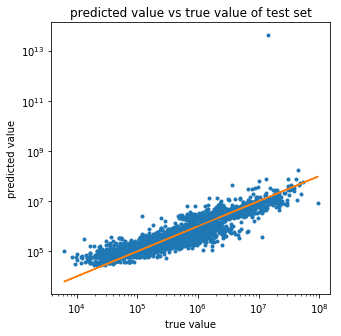

In [106]:
pred_value_plot(np.hstack((Y_test1,Y_test2)),np.hstack((Y_test1_pred,Y_test2_pred)))

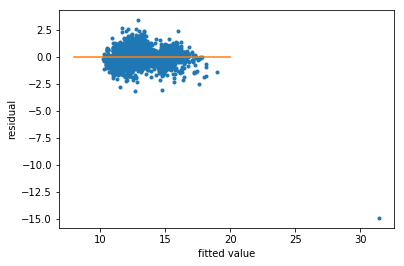

In [107]:
residual_plot(np.hstack((Y_test1,Y_test2)),np.hstack((Y_test1_pred,Y_test2_pred)))

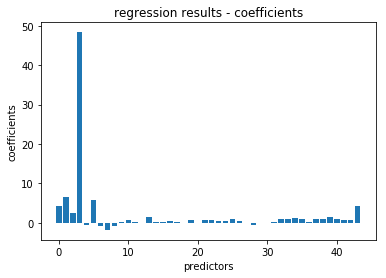

In [108]:
coef_plot(huber1.coef_)

In [109]:
huber1.coef_

array([ 4.3185,  6.5971,  2.5439, 48.3482, -0.6289,  5.751 , -0.906 ,
       -1.8307, -0.7734,  0.0917,  0.7082,  0.1059, -0.0096,  1.3916,
        0.1643,  0.0793,  0.4813,  0.1933, -0.1121,  0.6984, -0.0562,
        0.7928,  0.5732,  0.4108,  0.5073,  1.0668,  0.5352, -0.0721,
       -0.6321,  0.0128, -0.1788,  0.1656,  0.9952,  0.8327,  1.217 ,
        0.8162,  0.0688,  1.0468,  0.8355,  1.3379,  0.9427,  0.58  ,
        0.648 ,  4.344 ])

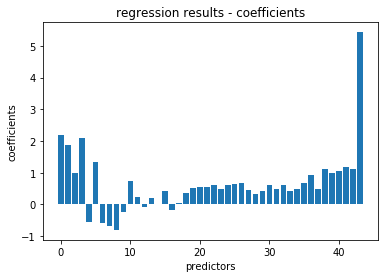

In [110]:
coef_plot(huber2.coef_)

In [111]:
huber2.coef_

array([ 2.2015,  1.8576,  0.997 ,  2.0914, -0.5545,  1.3222, -0.5821,
       -0.6845, -0.8054, -0.2468,  0.7225,  0.2366, -0.0705,  0.2007,
        0.0184,  0.4359, -0.1852,  0.034 ,  0.3532,  0.528 ,  0.5438,
        0.5522,  0.6054,  0.4709,  0.5959,  0.6576,  0.6658,  0.4571,
        0.3306,  0.411 ,  0.6004,  0.4851,  0.6099,  0.4134,  0.4699,
        0.6756,  0.9342,  0.4997,  1.112 ,  1.0027,  1.0378,  1.1681,
        1.1094,  5.4299])